In [1]:
!pip install optuna optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Activation, Multiply, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
import optuna
import math
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [3]:
# (input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data()
# input_X_train = input_X_train.astype('float32') / 255
# input_X_test = input_X_test.astype('float32') / 255
# input_X_train = preprocess_input(input_X_train)
# input_X_test = preprocess_input(input_X_test)

# output_Y_train = to_categorical(output_y_train, 100)
# output_Y_test = to_categorical(output_y_test, 100)

In [4]:
(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data()

# Preprocess the input data
input_X_train = preprocess_input(input_X_train.astype('float32'))
input_X_test = preprocess_input(input_X_test.astype('float32'))

# Splitting the original training data to train and validation sets
input_X_train, input_X_val, output_y_train, output_y_val = train_test_split(
    input_X_train, output_y_train, test_size=0.2, random_state=42)

# Convert class vectors to binary class matrices
output_Y_train = to_categorical(output_y_train, 100)
output_Y_test = to_categorical(output_y_test, 100)
output_Y_val = to_categorical(output_y_val, 100)

169001437/169001437 [==============================] - 4s 0us/step


In [5]:
# Define the attention mechanism
def attach_attention_module(net, attention_module='se_block'):
    if attention_module == 'se_block':
        net = squeeze_excite_block(net)
    return net

def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

# Create the model
def create_model(trial):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = True

    x = base_model.output
    x = attach_attention_module(x)  # Attach attention module
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(trial.suggest_float('dropout_rate', 0.3, 0.5))(x)
    predictions = Dense(100, activation='softmax')(x)

    # optimizer = SGD(lr=0.1, momentum=0.9, decay=0.01)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
best_accuracy = 0  # Initial best accuracy
best_history = None  # Variable to store the best model's history

def objective(trial):
    global best_accuracy, best_history
    # Create model with current trial's suggested hyperparameters
    model = create_model(trial)

    # Setup data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,  # Slightly reduced
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8, 1.2],
        shear_range=0.1,  # Slightly reduced
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Setup callbacks
    checkpoint_filepath = 'best_model_trial_{}.h5'.format(trial.number)
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

    # Train the model
    history = model.fit(datagen.flow(input_X_train, output_Y_train, batch_size=128),
                        epochs=100,
                        validation_data=(input_X_val, output_Y_val),
                        callbacks=[checkpoint, early_stopping],
                        verbose=1)

    current_val_accuracy = max(history.history['val_accuracy'])

    if current_val_accuracy > best_accuracy:  # Check if the current model is the best one
        best_accuracy = current_val_accuracy
        best_history = history.history  # Update the best_history with the current model's history
        print(f"New best model with validation accuracy: {best_accuracy} saved")

    return current_val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)  # Adjust the number of trials as needed

# Load the best model from the trial that provided the highest validation accuracy
best_trial = study.best_trial
print('Best trial number:', best_trial.number)
best_model_path = 'best_model_trial_{}.h5'.format(best_trial.number)
best_model = load_model(best_model_path)

# Output the best model's hyperparameters
print("Best trial's hyperparameters:")
print(f"Dropout rate: {best_trial.params['dropout_rate']}")
print(f"Learning rate: {best_trial.params['learning_rate']}")

[I 2024-04-25 12:00:36,974] A new study created in memory with name: no-name-016c72d4-1d81-4400-82cc-c8628548e7b2


94765736/94765736 [==============================] - 0s 0us/step


<ipython-input-5-3fd358b96665>:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 3.5859 - accuracy: 0.1877
Epoch 1: val_accuracy improved from -inf to 0.33390, saving model to best_model_trial_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 50s 125ms/step - loss: 3.5859 - accuracy: 0.1877 - val_loss: 2.6971 - val_accuracy: 0.3339
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 2.5298 - accuracy: 0.3656
Epoch 2: val_accuracy improved from 0.33390 to 0.40620, saving model to best_model_trial_0.h5
313/313 [==============================] - 37s 117ms/step - loss: 2.5298 - accuracy: 0.3656 - val_loss: 2.3348 - val_accuracy: 0.4062
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 2.1944 - accuracy: 0.4324
Epoch 3: val_accuracy improved from 0.40620 to 0.44960, saving model to best_model_trial_0.h5
313/313 [==============================] - 37s 117ms/step - loss: 2.1944 - accuracy: 0.4324 - val_loss: 2.1315 - val_accuracy: 0.4496
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 2.0034 - accuracy: 0.4692
Epoch 4: val_accuracy improved from 0.44960 to 0.46780, saving model to best_model_trial_0.h5
313/313 [================

[I 2024-04-25 12:15:16,698] Trial 0 finished with value: 0.5789999961853027 and parameters: {'dropout_rate': 0.40312251007669303, 'learning_rate': 0.0003698119115502871}. Best is trial 0 with value: 0.5789999961853027.


New best model with validation accuracy: 0.5789999961853027 saved
Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 3.5267 - accuracy: 0.1970
Epoch 1: val_accuracy improved from -inf to 0.28480, saving model to best_model_trial_1.h5
313/313 [==============================] - 43s 120ms/step - loss: 3.5267 - accuracy: 0.1970 - val_loss: 2.9141 - val_accuracy: 0.2848
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 2.4958 - accuracy: 0.3656
Epoch 2: val_accuracy improved from 0.28480 to 0.39620, saving model to best_model_trial_1.h5
313/313 [==============================] - 37s 117ms/step - loss: 2.4958 - accuracy: 0.3656 - val_loss: 2.3310 - val_accuracy: 0.3962
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 2.1689 - accuracy: 0.4318
Epoch 3: val_accuracy improved from 0.39620 to 0.44950, saving model to best_model_trial_1.h5
313/313 [==============================] - 36s 117ms/step - loss: 2.1689 - accuracy: 0.4318 - va

[I 2024-04-25 12:27:26,796] Trial 1 finished with value: 0.5515000224113464 and parameters: {'dropout_rate': 0.3202572538854486, 'learning_rate': 0.00041169421144257774}. Best is trial 0 with value: 0.5789999961853027.


Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 3.7215 - accuracy: 0.1593
Epoch 1: val_accuracy improved from -inf to 0.19360, saving model to best_model_trial_2.h5
313/313 [==============================] - 43s 120ms/step - loss: 3.7215 - accuracy: 0.1593 - val_loss: 3.5066 - val_accuracy: 0.1936
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 2.8610 - accuracy: 0.2931
Epoch 2: val_accuracy improved from 0.19360 to 0.30080, saving model to best_model_trial_2.h5
313/313 [==============================] - 36s 116ms/step - loss: 2.8610 - accuracy: 0.2931 - val_loss: 2.9773 - val_accuracy: 0.3008
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 2.5776 - accuracy: 0.3503
Epoch 3: val_accuracy did not improve from 0.30080
313/313 [==============================] - 35s 113ms/step - loss: 2.5776 - accuracy: 0.3503 - val_loss: 3.3072 - val_accuracy: 0.2784
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 

[I 2024-04-25 12:47:34,057] Trial 2 finished with value: 0.5550000071525574 and parameters: {'dropout_rate': 0.4768193816938566, 'learning_rate': 0.0008069054302657859}. Best is trial 0 with value: 0.5789999961853027.


Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 4.5287 - accuracy: 0.0213
Epoch 1: val_accuracy improved from -inf to 0.01500, saving model to best_model_trial_3.h5
313/313 [==============================] - 43s 120ms/step - loss: 4.5287 - accuracy: 0.0213 - val_loss: 5.1018 - val_accuracy: 0.0150
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 4.2145 - accuracy: 0.0406
Epoch 2: val_accuracy improved from 0.01500 to 0.03920, saving model to best_model_trial_3.h5
313/313 [==============================] - 37s 118ms/step - loss: 4.2145 - accuracy: 0.0406 - val_loss: 4.5858 - val_accuracy: 0.0392
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 4.1443 - accuracy: 0.0476
Epoch 3: val_accuracy did not improve from 0.03920
313/313 [==============================] - 35s 113ms/step - loss: 4.1443 - accuracy: 0.0476 - val_loss: 4.4908 - val_accuracy: 0.0315
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 

[I 2024-04-25 13:17:38,975] Trial 3 finished with value: 0.21230000257492065 and parameters: {'dropout_rate': 0.31884803848208115, 'learning_rate': 0.007816480836290916}. Best is trial 0 with value: 0.5789999961853027.


Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 4.4200 - accuracy: 0.0337
Epoch 1: val_accuracy improved from -inf to 0.01870, saving model to best_model_trial_4.h5
313/313 [==============================] - 44s 120ms/step - loss: 4.4200 - accuracy: 0.0337 - val_loss: 4.7968 - val_accuracy: 0.0187
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 4.0294 - accuracy: 0.0667
Epoch 2: val_accuracy did not improve from 0.01870
313/313 [==============================] - 35s 113ms/step - loss: 4.0294 - accuracy: 0.0667 - val_loss: 4.8480 - val_accuracy: 0.0184
Epoch 3/100
313/313 [==============================] - ETA: 0s - loss: 3.8461 - accuracy: 0.0966
Epoch 3: val_accuracy improved from 0.01870 to 0.06380, saving model to best_model_trial_4.h5
313/313 [==============================] - 37s 117ms/step - loss: 3.8461 - accuracy: 0.0966 - val_loss: 4.5566 - val_accuracy: 0.0638
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 

[I 2024-04-25 14:02:00,564] Trial 4 finished with value: 0.357699990272522 and parameters: {'dropout_rate': 0.3717953247643471, 'learning_rate': 0.005138053549209233}. Best is trial 0 with value: 0.5789999961853027.


Best trial number: 0
Best trial's hyperparameters:
Dropout rate: 0.40312251007669303
Learning rate: 0.0003698119115502871


In [7]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(input_X_test, output_Y_test, verbose=1)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

313/313 [==============================] - 3s 6ms/step - loss: 1.7305 - accuracy: 0.5813
Test Loss: 1.731
Test Accuracy: 0.581


In [8]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [9]:
from tensorflow.keras.metrics import Precision, Recall

# Re-compile the best model with Adam optimizer and additional metrics
best_model.compile(
    optimizer=Adam(lr=best_trial.params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Evaluate the model on the test set
results = best_model.evaluate(input_X_test, output_Y_test, verbose=1)

# Extract metrics
test_loss, test_accuracy, test_precision, test_recall = results

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Calculate and print F1 Score
if (test_precision + test_recall) == 0:
    print("Precision and recall are both zero; F1 score is undefined.")
else:
    test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print(f"Test F1 Score: {test_f1_score:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


313/313 [==============================] - 4s 7ms/step - loss: 1.7305 - accuracy: 0.5813 - precision: 0.6854 - recall: 0.5296
Test Loss: 1.7305
Test Accuracy: 0.5813
Test Precision: 0.6854
Test Recall: 0.5296
Test F1 Score: 0.5975


In [10]:
import matplotlib.pyplot as plt

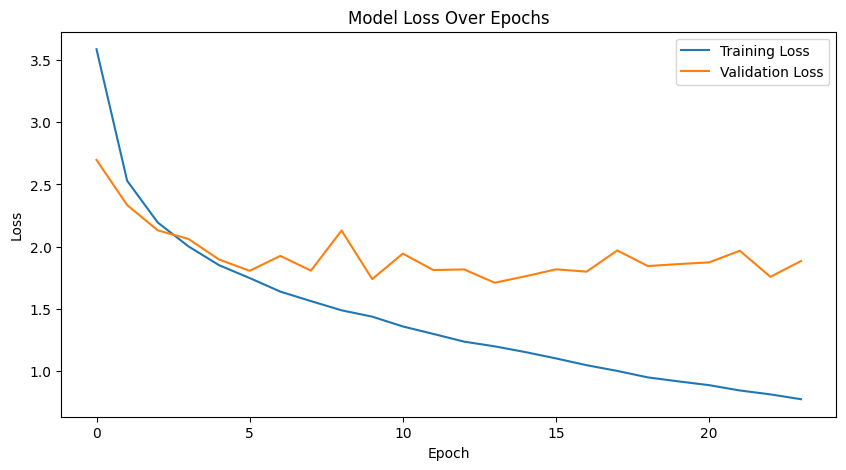

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


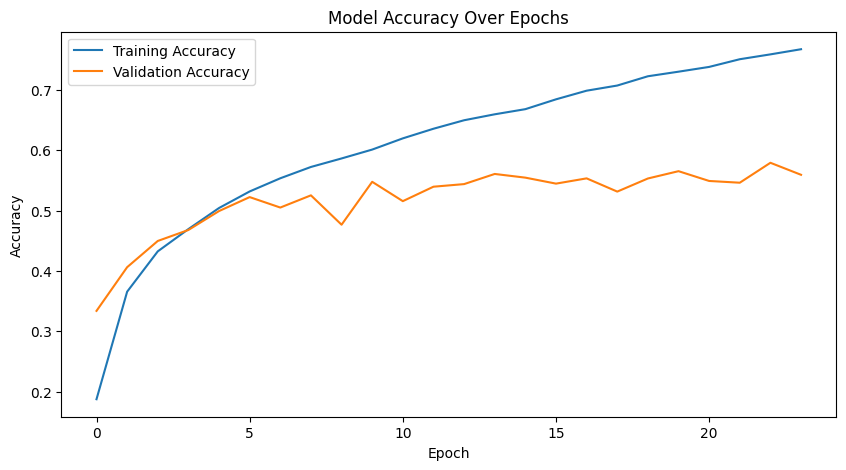

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
